In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
import os
import sys
import holidays
from scipy.signal import deconvolve, find_peaks
sys.path.append('../lib/')
from utils import *
from analysis import * 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', 
                   skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 
             'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + 
                               Electric['Hour'].astype(str) + ':' + 
                               Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [3]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


<AxesSubplot:>

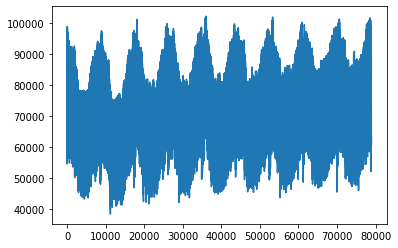

In [4]:
feature = 'Load'
df = resampling_data(df=Electric, feature=feature, resample_cost='h')

df.reset_index(drop=False, inplace=True)
df['Day'] = df.Date.dt.day_of_week
poland_holidays = holidays.CountryHoliday('Poland')
df['Holiday'] = df.Date.apply(lambda x: x in poland_holidays)
df['Day id'] = df.Date.dt.day_of_year
peaks_up, _  = find_peaks(df[feature], distance=5000)
peaks_down, _  = find_peaks(-df[feature], distance=5000)
peaks = np.concatenate(([0], peaks_down, peaks_up, [len(df)-1]))
df.loc[peaks, feature] = np.nan
df[feature].interpolate(inplace=True)

df = df[~df.Load.isna()].reset_index(drop=True)
df[feature].plot()

In [5]:
seasonal_comp = fourierExtrapolation(
    df[feature].to_numpy(),
    n_harm=10)


df['Load_lin_seasonal'] = linear_fit(x=df.index, y=df[feature]) + seasonal_comp
df['Load_real_comp'] = df[feature] - df['Load_lin_seasonal']
df.set_index('Date', inplace=True)

df

,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin_seasonal,Load_real_comp
Date,,,,,,,,
2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1,76289.838217,-15469.938217
2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1,76290.338776,-18420.538776
2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1,76290.836251,-20618.036251
2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1,76291.330643,-20959.630643
2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1,76291.821951,-21764.821951
...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366,82543.526730,-12153.226730
2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366,82544.042702,-15618.942702
2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366,82544.555592,-17644.455592


In [6]:
def add_linear_seasonal_terms(df, new_col='Load', signal_col='Load_real_comp', col='Load_lin_seasonal'):
    """Lin_column must be the first column.

    Args:
        df (_type_): _description_
        lin_column (str, optional): _description_. Defaults to 'Load_lin'.
    """
    df = df.add(df[col], axis=0)
    
    del df[col]
    df.columns = df.columns.str.replace(signal_col, new_col)

    return df


def psf_forecasting(df: pd.DataFrame, cut_day: str, 
                    feature: str='Load_real_comp') -> pd.DataFrame:
    """
    Function which implements the Pattern Sequence Forecast. 
    in first place it computes the PSF for the working days and the holidays
    then it constructs the forecasts using the knowledge of the future days

    Args:
        df (pd.DataFrame): Table which contains the information of the timeseries 
                           and if a day is an holiday or not
        cut_day (str): day used to split previous Table into train and test set
        feature (str, optional): timeseries information used to perform the algorithm. Defaults to 'Load_real_comp'.

    Returns:
        pd.DataFrame: forecasts
    """
    
    train_set = df[df.index < pd.to_datetime(cut_day, format='%Y-%m-%d')].copy()
    test_set = df[df.index >= pd.to_datetime(cut_day, format='%Y-%m-%d')].copy()
    
    n_days_ahead = len(test_set.index.day_of_year.unique())
    
    working_days = train_set[~train_set.Holiday]
    festivities = train_set[train_set.Holiday]
    
    f = {feature: ['mean', q1, q2], 'Load_lin_seasonal': ['mean', q1, q2]}
    pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
    pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)    

    forecasting = []
    for day in pd.date_range(cut_day, periods=n_days_ahead, freq="d"):
        if any(day.day_of_year == festivities['Day id']):
            forecasting.append(pred_festivities.loc[day.day_of_year][feature].to_numpy())
        else:
            forecasting.append(pred_working_days.loc[day.day_of_week][feature].to_numpy())

    forecasting = np.concatenate(forecasting)
    
    tmp = df[['Load_lin_seasonal', feature]].copy()
    n = len(forecasting) - len(test_set)

    tmp.loc[tmp.index >= cut_day,
            ['forecast', 'q1_forecast', 'q2_forecast']] = forecasting[:-n, :]

    return add_linear_seasonal_terms(tmp)

In [7]:
def plot_model_forecasting(df, cut_day, model, feature = 'Load'):
   
    freq = df.index.inferred_freq 
    if freq == 'W-SUN':
        weeks = 52
        n_weeks = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days // 7
        time_interval = n_weeks
        interval_type = 'weeks'     
    else:
        weeks = 2
        n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days
        time_interval = n_days
        interval_type = 'days'
        
    date = pd.to_datetime(cut_day) - dt.timedelta(weeks=weeks)
    cut_mask = df.index >= cut_day
    date_mask = df.index > date
 
    ax = latex_settings()
    df.loc[date_mask, [feature]].plot(ax=ax, color='b', lw=1)
    df.loc[cut_mask, [feature, 'forecast']].plot(ax=ax, color=['g', 'orange'], lw=1)
    ax.fill_between(x=df[date_mask].index, y1=df[date_mask].q1_forecast,
                    y2=df[date_mask].q2_forecast, color='orange', alpha=0.5, lw=1)
    ax.grid()
    ax.set_ylabel('Load (MW)')
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_title(f'Poland Electricity Load ({time_interval} {interval_type})')
    leg = plt.legend(loc="lower left", ncol=4, fancybox=True, framealpha=0.5,
                     fontsize=7.5,
                     labels=['Train set', 'Test set', 'Forecast', '95% CI'])

    file_path = f'../Images/{model}/'
    file = f'{model}_{freq}_{time_interval}{interval_type}.png'
    if os.path.isfile(file_path + file):
        pass
    else:    
        plt.savefig(file_path + file, dpi=800, transparent=True)

In [ ]:
cut_dates = ['2016-12-25'] + [df.index[-1] - timedelta(days=i*30) for i in range(1, 12)]
cut_dates.append('2016-01-02')

dfs = []
for cut_date in cut_dates:
    tmp = psf_forecasting(df, cut_day=cut_date)
    dfs.append(tmp)

In [ ]:
file_path = "../Results/PSF/"
days = [7] + list(range(30, 360, 30)) + [365]

for df1, day in zip(dfs, days):
    freq = df1.index.inferred_freq
    file = f"PSF_{freq}_{day}days.csv"
    df1[df1.forecast.notna()].to_csv(file_path+file, index=True)

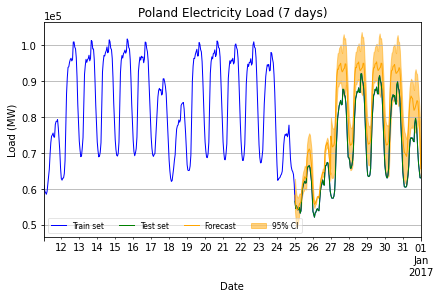

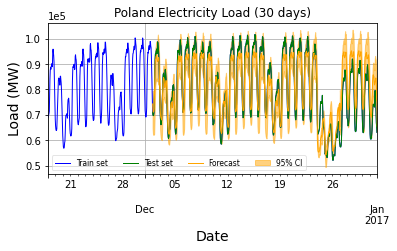

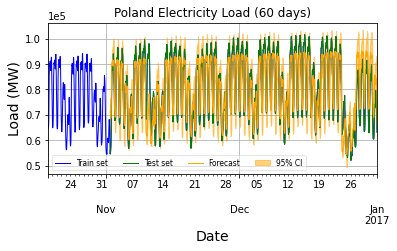

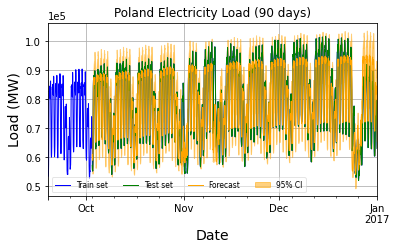

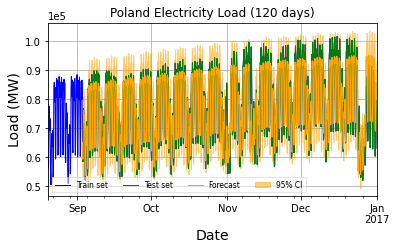

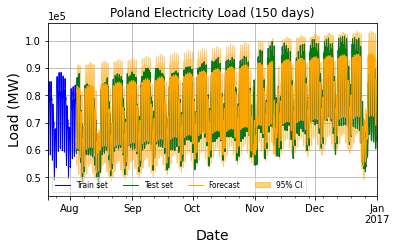

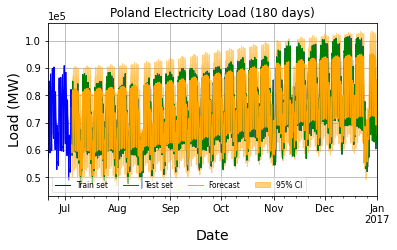

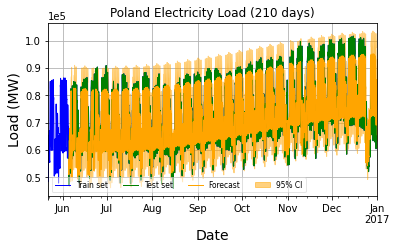

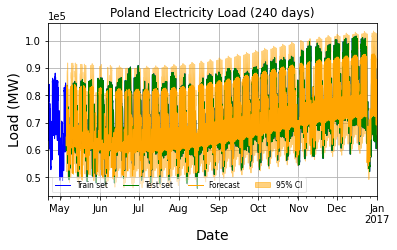

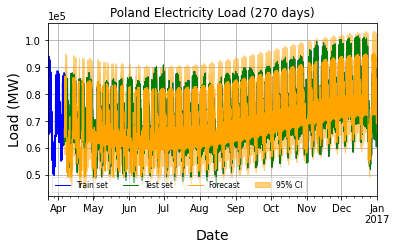

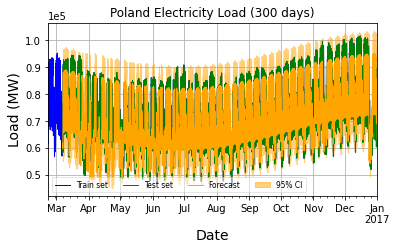

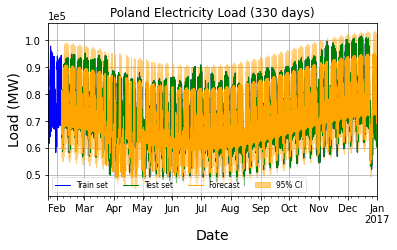

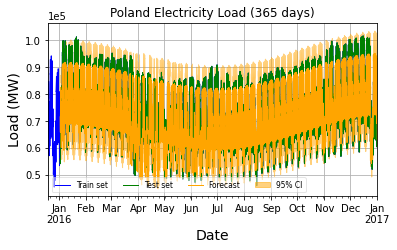

In [14]:
cut_dates = ['2016-12-25'] + [df.index[-1] - timedelta(days=i*30) for i in range(1, 12)]
cut_dates.append('2016-01-02')

model = 'PSF' 
results_path = f'../Results/{model}/'

days = [7] + list(range(30, 360, 30)) + [365]

dfs = []
for ndays, cut_date in zip(days, cut_dates):
    file = f'{model}_H_{ndays}days.csv'
    res = pd.read_csv(results_path + file, index_col=['Date'], parse_dates=['Date'])
    tmp = df[['Load']].copy()
    tmp.loc[res.index, res.columns] = res    
    
    plot_model_forecasting(df=tmp, cut_day=cut_date, model=model)
    
    dfs.append(tmp)

In [8]:
def accuracy_metric(dfs, cut_dates):
    accuracy, mapes, rel_err = [], [], []
    for df in dfs:
        mask = df.forecast.notna()
        tmp = df[mask].copy()
        
        rel_err_mean = np.mean((tmp['q2_forecast'] - tmp['q1_forecast']) / tmp['forecast'])
        rel_err.append(round(rel_err_mean, 4))
        
        x = df.loc[mask, 'forecast']
        y = df.loc[mask, 'Load']
        mapes.append(round(mape(x, y), 4))
         
        mask_ci = (tmp['q1_forecast'] <= tmp['Load']) & (tmp['Load'] <= tmp['q2_forecast'])
        accuracy.append(round(len(tmp[mask_ci]) / len(tmp), 4))
        
    tmp = pd.DataFrame(
        [cut_dates, accuracy, mapes, rel_err],
        index=['cut_date', 'accuracy', 'mape', 'rel_err']
        ).T
    tmp.iloc[:, 1:] = tmp.iloc[:, 1:].multiply(100)
    
    return tmp


#tmp = accuracy_metric(dfs, cut_dates)
#tmp

## Data Denoising

### Wavelet method

In [57]:
def tasks_automatization(df, feature, cut_dates):
    df = resampling_data(df=df, feature=feature, resample_cost='h')

    df.reset_index(drop=True, inplace=True)
    df['Day'] = df.index.day_of_week
    poland_holidays = holidays.CountryHoliday('Poland')
    df['Holiday'] = df.Date.apply(lambda x: x in poland_holidays)
    df['Day id'] = df.index.day_of_year
    peaks_up, _  = find_peaks(df[feature], distance=5000)
    peaks_down, _  = find_peaks(-df[feature], distance=5000)
    peaks = np.concatenate(([0], peaks_down, peaks_up, [len(df)-1]))
    df.loc[peaks, feature] = np.nan
    df[feature].interpolate(inplace=True)

    df = df[~df[feature].isna()].reset_index(drop=True)

    seasonal_comp = fourierExtrapolation(
        df[feature].to_numpy()
        n_harm=10)

    df['Load_lin_seasonal'] = linear_fit(x=df.index, y=df[feature]) + seasonal_comp
    df['Load_real_comp'] = df[feature] - df['Load_lin_seasonal']
    df.set_index('Date', inplace=True)

    dfs = []
    for cut_date in cut_dates:
        tmp = psf_forecasting(df, cut_day=cut_date)
        dfs.append(tmp)
    
    return accuracy_metric(dfs=dfs, cut_dates=cut_dates)

In [58]:
wave = 'coif5'
threshold = 0.01
Load_denoised = wavelet_filter(Electric.Load.to_numpy(), wavelet=wave, threshold=threshold)

Electric['Load_denoised'] = Load_denoised

tasks_automatization(Electric, 'Load_denoised', cut_dates)

AttributeError: 'RangeIndex' object has no attribute 'day_of_week'

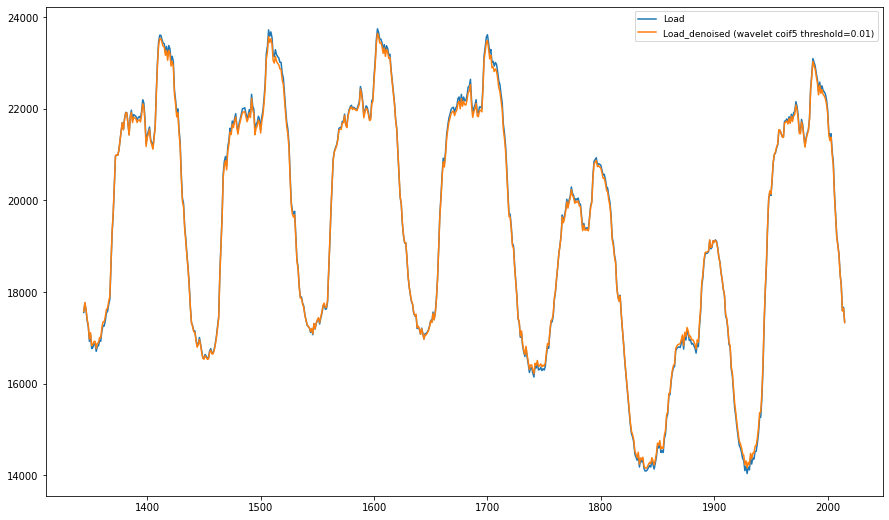

In [52]:
plt.figure(figsize=(15, 9))

plt.plot(Electric.Load[96*7*2:96*7*3], label='Load')
plt.plot(Electric.Load_denoised[96*7*2:96*7*3], label=f'Load_denoised (wavelet {wave} threshold={threshold})')
plt.legend()

### BayesShrink method for universal threshold for wavelet denoising

In [12]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)


# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(Electric.Load.to_numpy())


bayes_coif5 = denoise_wavelet(Electric.Load.to_numpy(), method='BayesShrink', mode='soft',
                                wavelet=wave, sigma=sigma_est, rescale_sigma=True)

bayes_db1 = denoise_wavelet(Electric.Load.to_numpy(), method='BayesShrink', mode='soft',
                           wavelet='db1', rescale_sigma=True)

bayes_sym4 = denoise_wavelet(Electric.Load.to_numpy(), method='BayesShrink', mode='soft',
                           wavelet='sym4', rescale_sigma=True)

bayes_sym5 = denoise_wavelet(Electric.Load.to_numpy(), method='BayesShrink', mode='soft',
                           wavelet='sym5', rescale_sigma=True)

In [43]:
from skimage.restoration._denoise import _bayes_thresh

data = Electric.Load.to_numpy()
maxlev = pywt.dwt_max_level(len(data), wave)
var = sigma_est ** 2

coeffs = pywt.wavedec(data, wave, level=maxlev)
dcoeff = coeffs[1:]

In [44]:
# Apply threshold to detail coefficients
for i in range(1, len(coeffs)):
    thrs = _bayes_thresh(coeffs[i], var)
    coeffs[i] = pywt.threshold(coeffs[i], mode='soft', 
                               value=thrs)

In [46]:
datarec = pywt.waverec(coeffs, wave)

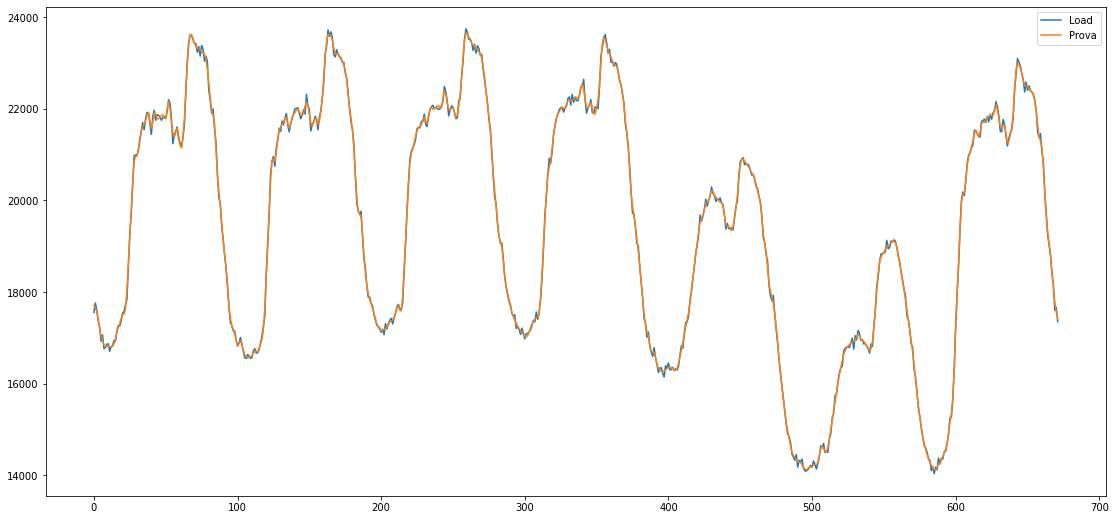

In [50]:
plt.figure(figsize=(19,9))

plt.plot(Electric.Load.to_numpy()[96*7*2:96*7*3], label='Load')
plt.plot(datarec[96*7*2:96*7*3], label='Prova')
#plt.plot(bayes_coif5[96*7*2:96*7*3], label='Bayes')
plt.legend()

In [52]:
cut_dates = ['2016-12-25'] + [df.index[-1] - timedelta(days=i*30) for i in range(1, 12)]
cut_dates.append('2016-01-02')

In [53]:
Electric['Load_denoised'] = datarec
tasks_automatization(Electric, 'Load_denoised', cut_dates)

AttributeError: 'DataFrame' object has no attribute 'Date'

In [68]:
Electric['Load_denoised'] = bayes_coif5
tasks_automatization(Electric, 'Load_denoised', cut_dates)

,cut_date,accuracy,mape,rel_err
0,2016-12-25,34.32,8.91,12.58
1,2016-12-02,79.33,5.0,14.09
2,2016-11-02,83.97,4.66,14.09
3,2016-10-03,87.37,4.11,14.33
4,2016-09-03,90.0,3.78,14.86
5,2016-08-04,91.11,3.56,15.14
6,2016-07-05,92.32,3.41,15.54
7,2016-06-05,89.53,3.88,15.38
8,2016-05-06,86.7,4.49,15.05
9,2016-04-06,83.86,5.35,14.5


In [69]:
Electric['Load_denoised'] = bayes_db1
tasks_automatization(Electric, 'Load_denoised', cut_dates)

,cut_date,accuracy,mape,rel_err
0,2016-12-25,33.73,8.9,12.53
1,2016-12-02,79.33,4.98,14.04
2,2016-11-02,83.9,4.64,14.04
3,2016-10-03,87.27,4.09,14.28
4,2016-09-03,89.97,3.76,14.8
5,2016-08-04,91.11,3.54,15.08
6,2016-07-05,92.27,3.39,15.48
7,2016-06-05,89.45,3.85,15.32
8,2016-05-06,86.62,4.47,14.99
9,2016-04-06,83.83,5.33,14.44


In [70]:
Electric['Load_denoised'] = bayes_sym4
tasks_automatization(Electric, 'Load_denoised', cut_dates)

,cut_date,accuracy,mape,rel_err
0,2016-12-25,34.32,8.91,12.57
1,2016-12-02,79.61,5.0,14.09
2,2016-11-02,83.9,4.66,14.08
3,2016-10-03,87.37,4.11,14.33
4,2016-09-03,90.11,3.78,14.85
5,2016-08-04,91.22,3.56,15.14
6,2016-07-05,92.41,3.42,15.53
7,2016-06-05,89.59,3.88,15.38
8,2016-05-06,86.76,4.49,15.05
9,2016-04-06,83.92,5.35,14.5


In [73]:
Electric['Load_denoised'] = bayes_sym5
tasks_automatization(Electric, 'Load_denoised', cut_dates)

,cut_date,accuracy,mape,rel_err
0,2016-12-25,34.32,8.91,12.58
1,2016-12-02,79.33,5.0,14.09
2,2016-11-02,83.97,4.66,14.09
3,2016-10-03,87.46,4.11,14.34
4,2016-09-03,90.11,3.78,14.86
5,2016-08-04,91.2,3.56,15.15
6,2016-07-05,92.34,3.41,15.54
7,2016-06-05,89.55,3.88,15.39
8,2016-05-06,86.72,4.49,15.05
9,2016-04-06,83.89,5.35,14.51


In [137]:
Electric['Load_denoised'] = imf.sum(axis=1) + y
tasks_automatization(Electric, 'Load_denoised', cut_dates)

,cut_date,accuracy,mape,rel_err
0,2016-12-25,34.32,8.88,12.59
1,2016-12-02,79.06,5.0,14.1
2,2016-11-02,83.83,4.66,14.1
3,2016-10-03,87.32,4.12,14.35
4,2016-09-03,90.11,3.79,14.87
5,2016-08-04,91.17,3.57,15.16
6,2016-07-05,92.36,3.42,15.56
7,2016-06-05,89.59,3.89,15.4
8,2016-05-06,86.77,4.5,15.07
9,2016-04-06,83.94,5.36,14.52


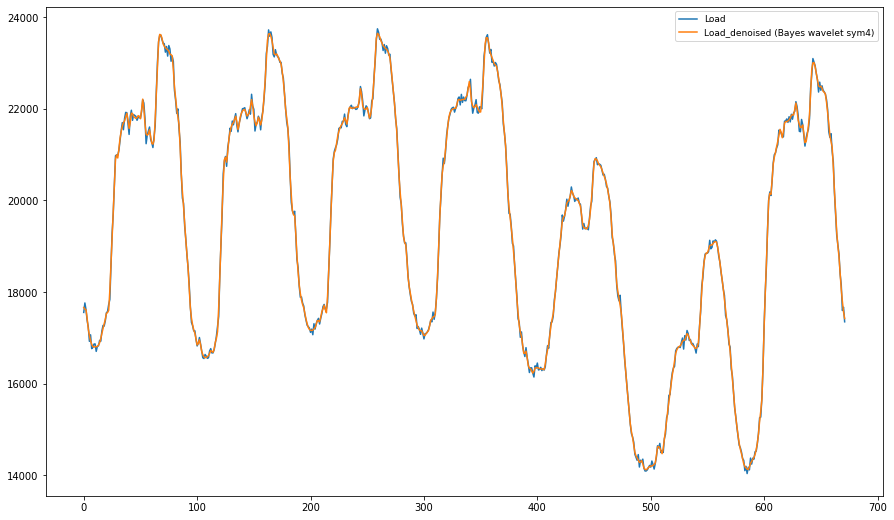

In [64]:
plt.figure(figsize=(15, 9))

plt.plot(Electric.Load.to_numpy()[96*7*2:96*7*3], label='Load')
plt.plot(bayes_sym4[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet sym4)')
plt.legend()

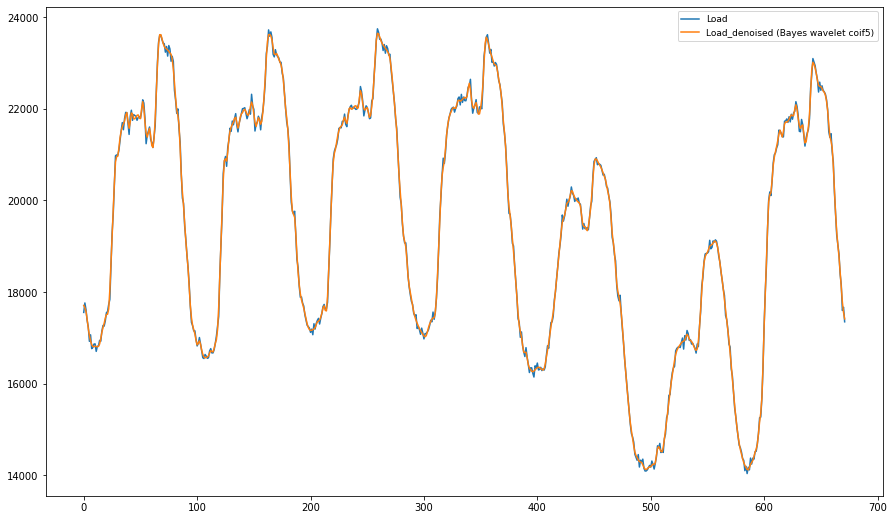

In [55]:
plt.figure(figsize=(15, 9))

plt.plot(Electric.Load.to_numpy()[96*7*2:96*7*3], label='Load')
plt.plot(bayes_coif5[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet coif5)')
plt.legend()

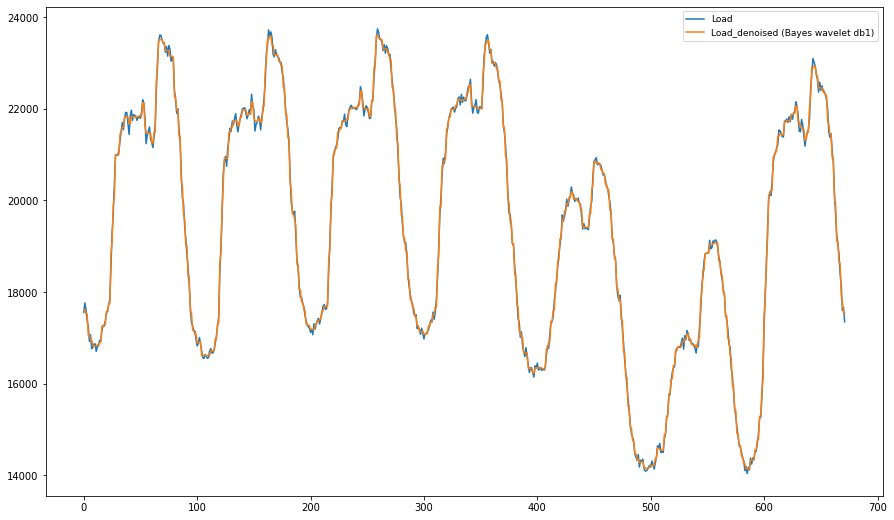

In [56]:
plt.figure(figsize=(15, 9))

plt.plot(Electric.Load.to_numpy()[96*7*2:96*7*3], label='Load')
plt.plot(bayes_db1[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet db1)')
plt.legend()

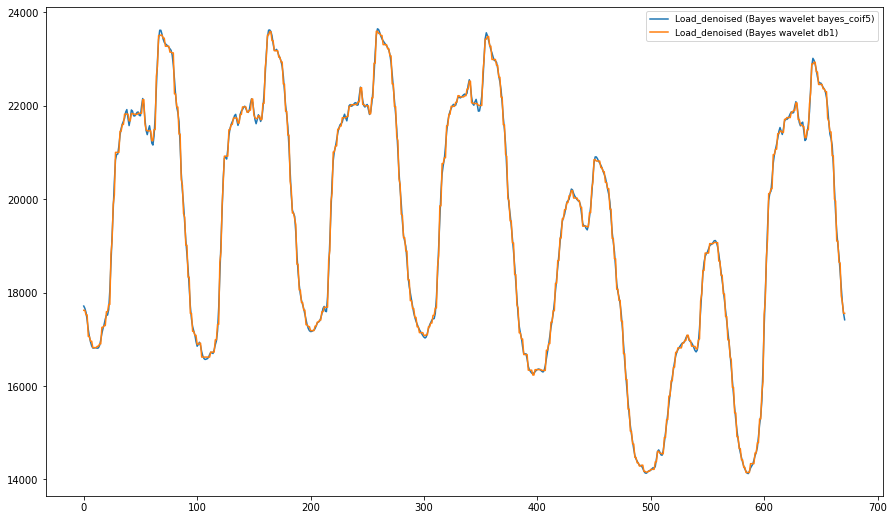

In [58]:
plt.figure(figsize=(15, 9))

plt.plot(bayes_coif5[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet bayes_coif5)')
plt.plot(bayes_db1[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet db1)')
plt.legend()

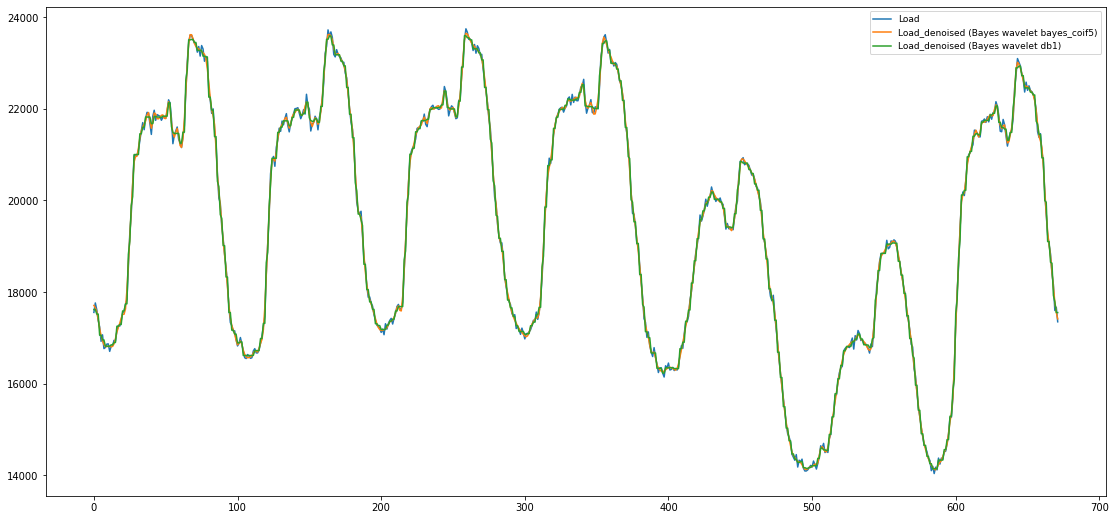

In [62]:
plt.figure(figsize=(19, 9))

plt.plot(Electric.Load.to_numpy()[96*7*2:96*7*3], label='Load')
#plt.plot(Electric.Load_denoised.to_numpy()[96*7*2:96*7*3], label=f'Load_denoised (wavelet {wave} threshold={threshold})')
plt.plot(bayes_coif5[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet bayes_coif5)')
plt.plot(bayes_db1[96*7*2:96*7*3], label='Load_denoised (Bayes wavelet db1)')
plt.legend()

In [74]:
import emd

In [ ]:
seasonal_comp = fourierExtrapolation(
    df[feature].to_numpy()
    n_harm=10)


df['Load_lin_seasonal'] = linear_fit(x=df.index, y=df[feature]) + seasonal_comp
df['Load_real_comp'] = df[feature] - df['Load_lin_seasonal']
df.set_index('Date', inplace=True)

df

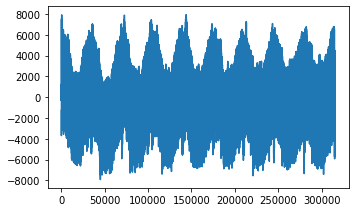

In [126]:
y = linear_fit(x=Electric.index, y=Electric.Load)
Load_detrend = Electric.Load.to_numpy() - y


plt.plot(Load_detrend)

In [127]:
# Run a mask sift
imf = emd.sift.mask_sift(Load_detrend, max_imfs=17) #, nprocesses=6)

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


(0.0, 100.0)

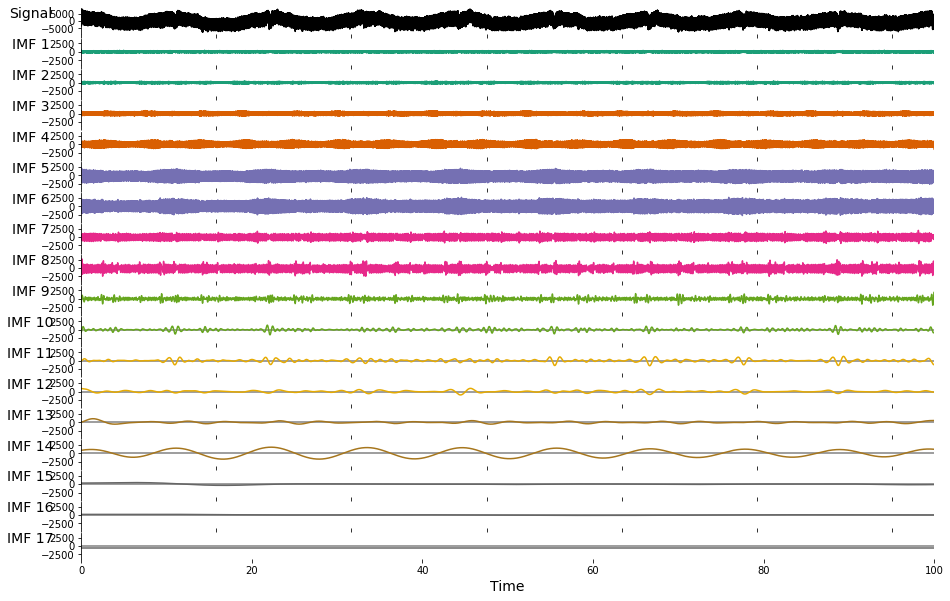

In [124]:
# Visualise the IMFs
sample_rate = 256
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True, fig=fig)
plt.xlim(0, 100)

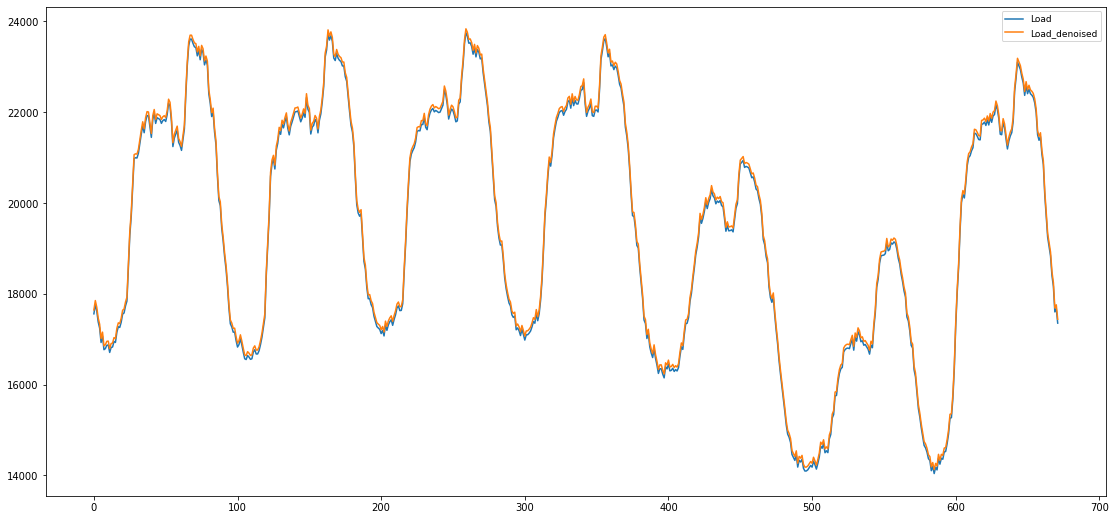

In [136]:
comp = 14 # unitl 16
x = imf[:, :].sum(axis=1) + y

plt.figure(figsize=(19, 9))

plt.plot(Electric.Load.to_numpy()[96*7*2:96*7*3], label='Load')
plt.plot(x[96*7*2:96*7*3], label='Load_denoised')
plt.legend()